In [1]:
import re
import os
import sys
sys.path.insert(0, '../')
import time

import numpy as np
rng = np.random.RandomState(0)

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import astropy.constants as constants
import astropy.units as u
import pandas as pd

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

from jas1101finalproject import GlobularCluster
from jas1101finalproject.plot import LogNorm, AsinhNorm, colorbar_non_mappable
from jas1101finalproject.utils import profile_binning, clip_quantile_nd
from jas1101finalproject.cluster import DBSCAN_Clustering

from jas1101finalproject.fit import sigmar_2
from jas1101finalproject.fit import DynamicNestedSampler

%load_ext autoreload
%autoreload 2

Generate realistic mock normalized data

Scale : 7.797 km / s


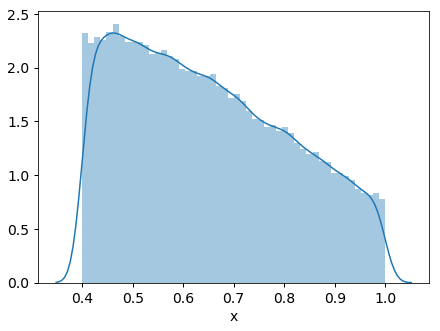

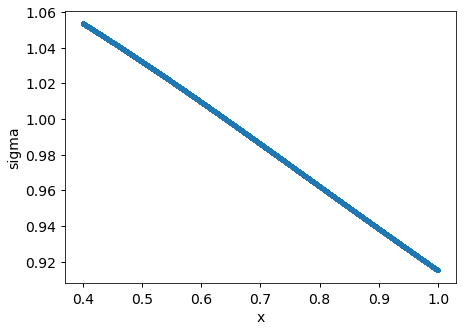

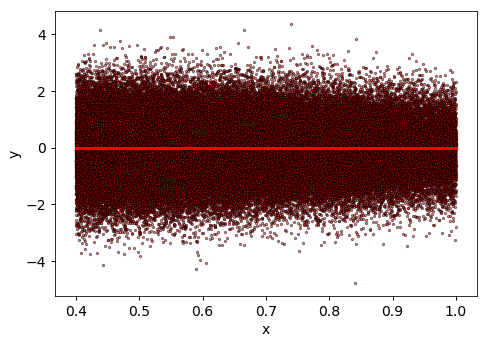

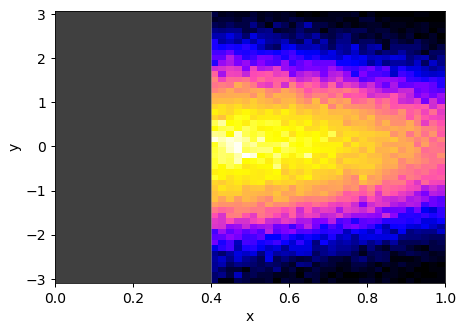

In [28]:
# parameter of GC
M_gc = 1e6
r_scale = 24
beta = 0.002 # ratio of M_BH
y_mean = 0  # mean pm

# generate mock r (normed)
x = stats.truncnorm(loc=0.4, scale=0.4, a=0, b=1.5).rvs(100000)
sig = np.sqrt(sigmar_2(x, M_gc, r_scale, beta)).to_value(u.km/u.s)

# normalize sigma
sig_n = np.sqrt(sigmar_2(1, M_gc, r_scale, beta)).to_value(u.km/u.s)
# sig = sig/sig_n

# generate mock pm (normed)
X = x[:, np.newaxis]
y0 = y_mean + rng.normal(0, sig, X.shape[0])

# normalize by std of data
scale = y0.std()
print("Scale : %.3f km / s"%scale)
y = y0 / scale

# distribution in x
sns.distplot(x)
plt.xlabel("x")
plt.show()

# sigma profile
plt.plot(x, sig / scale, '.')
plt.xlabel("x")
plt.ylabel("sigma")
plt.show()

# display x-y scatter 
plt.figure(figsize=(7,5))
X_ = np.linspace(x.min(), x.max(), 100)
plt.scatter(X[:, 0], y, c='r', s=5, edgecolors=(0, 0, 0), alpha=0.5)
plt.plot(X_, y_mean*np.ones_like(X_), 'r', lw=3)
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

# display x-y hist2d
plt.figure(figsize=(7,5))
H, xb, yb, _ = plt.hist2d(x, y, bins=50, range=[[0,1.],np.quantile(y, [0.001, 0.999])], norm=AsinhNorm(), cmap="gnuplot2")

plt.axvspan(0, x.min(), 0, color="gray", alpha=0.5)
plt.xlabel("x")
plt.ylabel("y") # normalized
plt.show()

Displaying impact from BH on sigma profile

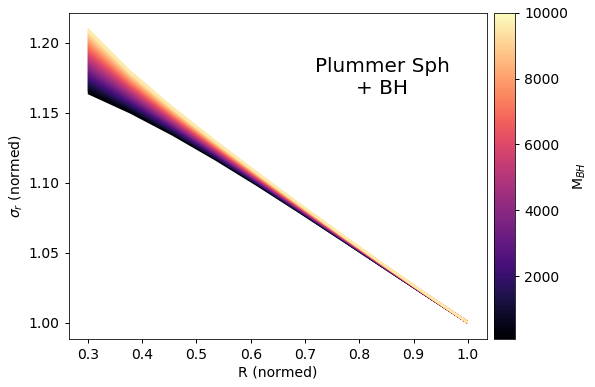

In [17]:
dist = 4.5e3 * u.pc
r_scale = 18.3 * u.arcmin.to(u.rad) * dist

R = np.linspace(0.3, 1, 10)

N_mod = 25
models = np.zeros((N_mod, len(R)))
f_BH_amp = np.linspace(1e-4,1e-2,N_mod)

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.set_prop_cycle('color', plt.cm.magma(np.linspace(0,1,N_mod-1)))
for i, f_bh in enumerate(f_BH_amp[:-1]):
    sig2 = sigmar_2(R, M_gc, r_scale.value, f_bh)
    sig2_n = sigmar_2(1, M_gc, r_scale.value, f_bh)
    
    # normalize by sigma at R = 1
    mod = np.sqrt(sig2 / sig2_n)
    models[i] = mod
    
    if i>0:
        plt.fill_between(R, models[i-1]-0.001, mod+0.001, edgecolor="None")
        
plt.xlabel("R (normed)")
plt.ylabel("$\sigma_r$ (normed)")
plt.text(0.75,0.8,"Plummer Sph\n+ BH", fontsize=20,
         ha="center", va="center", transform=ax.transAxes)
        
ax = colorbar_non_mappable(fig, ax, vmin=f_BH_amp.min()*M_gc,vmax=f_BH_amp.max()*M_gc)

Take a look by binnng in r

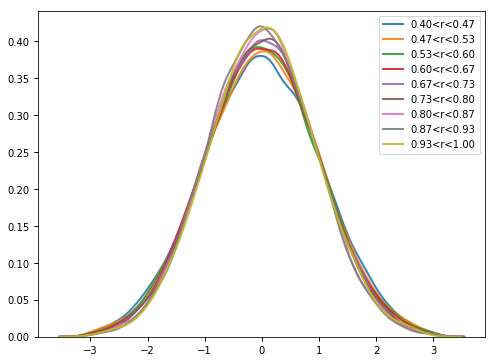

In [4]:
bins = np.linspace(x.min(), x.max(), 10)
r_rbin, z_rbin, z_bins = profile_binning(x, y, bins)

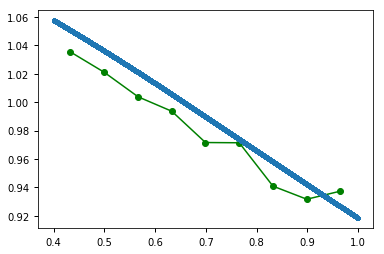

In [5]:
sigma_bins = np.array([np.std(z_bins[i]['pm']) for i in range(len(z_bins))])
plt.plot(r_rbin, sigma_bins, "g-o")
plt.plot(x, sig/scale, '.')

In [11]:
def prior(u, normalize=True):
    v = u.copy()
    
    v[0] = u[0] * 0.4 + 0.8  # M_GC
    v[1] = u[1] * 4 + 22     # r_scale
    v[2] = u[2] * 3 - 5      # log beta
    
    return v 

def loglike(v, normalize=True):
    M_gc, r_scale, logbeta = v
    
    M_gc = M_gc * 1e6
        
    beta = 10**logbeta
    
    ypred = 0
    sigma2 = sigmar_2(x, M_gc, r_scale, beta).to_value((u.km/u.s)**2)
    
    if normalize:
#         sigma2_n = sigmar_2(1, M_gc, r_scale, beta).to_value((u.km/u.s)**2)
        sigma2 = sigma2 / scale**2
    
    residsq = (ypred - y)**2 / sigma2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma2))

    if not np.isfinite(loglike):
        loglike = -1e100

    return loglike

In [18]:
def prior_2(u, normalize=True):
    v = u.copy()
    
    v[0] = u[0]               # M_GC [10^5 M_sun] / r_scale [pc]
    v[1] = u[1] * 6 + 2       # scale [km/s]
    v[2] = u[2] * 3 - 5       # log beta
    
    return v 

def loglike_2(v):
    
    r_scale = 10
    M_gc = v[0] * r_scale * 1e5
    scale = v[1]
    beta = 10**v[2]
    
    ypred = 0
    sigma2 = sigmar_2(x, M_gc, r_scale, beta).to_value((u.km/u.s)**2)
    
    sigma2 = sigma2 / scale**2
    
    residsq = (ypred - y)**2 / sigma2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma2))

    if not np.isfinite(loglike):
        loglike = -1e100

    return loglike

### Reparametrized Fitting (fitting normalization)

In [24]:
dsampler = DynamicNestedSampler(loglike_2, prior_2, ndim=3)
dsampler.run_fitting(nlive_init=400, maxbatch=4)


Opening new pool: # of CPU used: 3
Run Nested Fitting for the image... Dim of params: 3


iter: 3834 | batch: 4 | bound: 79 | nc: 2 | ncall: 24464 | eff(%): 15.672 | loglstar: -141735.684 < -141733.477 < -141734.251 | logz: -141739.012 +/-  0.155 | stop:  2.591                           



Finish Fitting! Total time elapsed: 1.1e+03 s

Pool Closed.


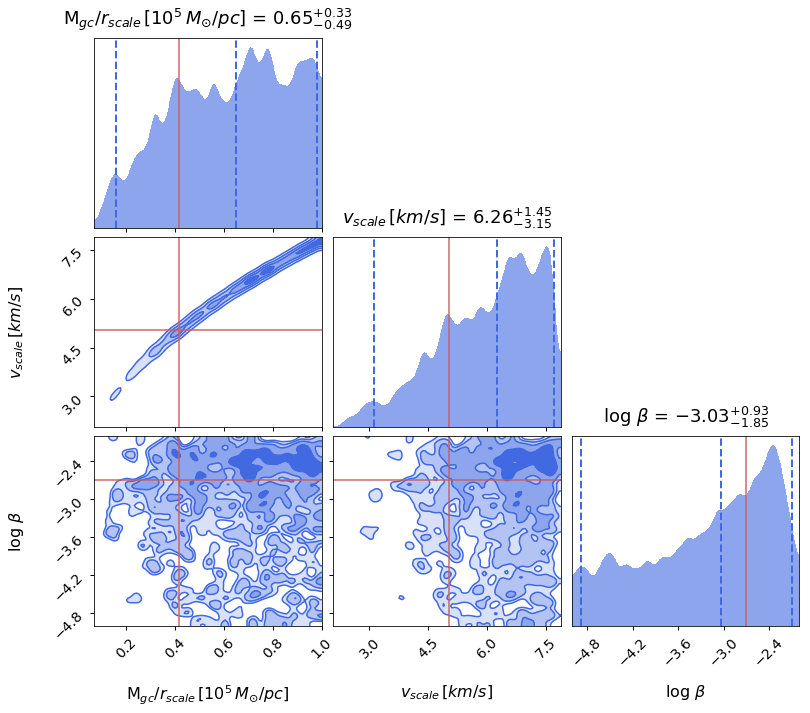

In [25]:
dsampler.cornerplot(truths=[M_gc/1e5/r_scale.value, scale, np.log10(beta)],
                    labels=[r'M$_{gc}/r_{scale}\,[10^5\,M_{\odot}/pc]$',
                            '$v_{scale}\,[km/s]$', r'log $\beta$'])

### Normalized Fitting (normalized by std of data)

In [19]:
dsampler = DynamicNestedSampler(loglike, prior, ndim=3)
dsampler.run_fitting()


Opening new pool: # of CPU used: 3
Run Nested Fitting for the image... Dim of params: 3


iter: 975 | batch: 2 | bound: 10 | nc: 6 | ncall: 9676 | eff(%): 10.076 | loglstar: -283507.272 < -283505.282 < -283505.518 | logz: -283509.475 +/-  0.270 | stop:  6.061                             


Finish Fitting! Total time elapsed: 892 s

Pool Closed.


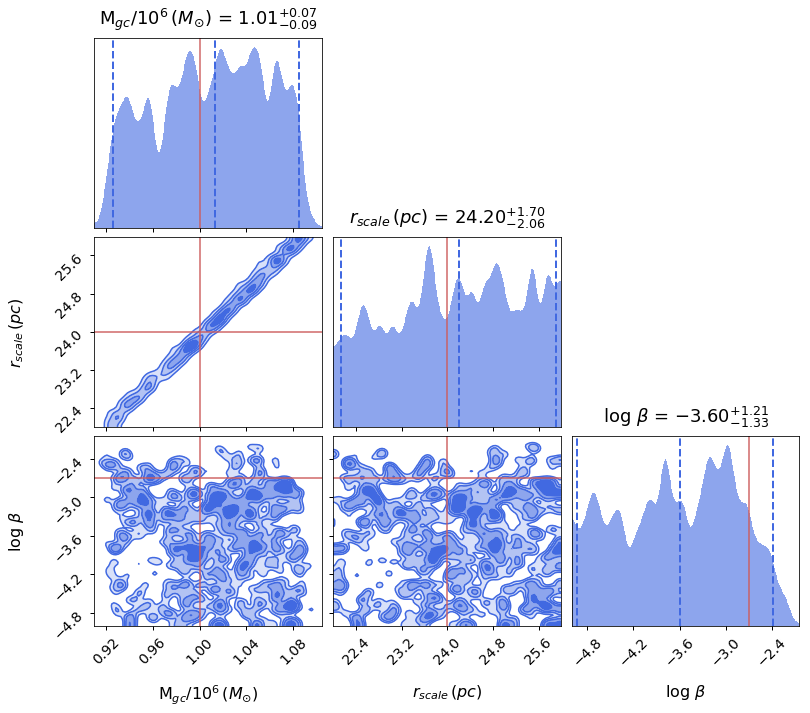

In [22]:
dsampler.cornerplot(truths=[M_gc/1e6, r_scale, np.log10(beta)],
                    labels=[r'M$_{gc}/10^6\,(M_{\odot})$',
                            '$r_{scale}\,(pc)$', r'log $\beta$'])

### Normalized Fitting (normalized by $\sigma(r=1)$)  w/ arbitrary $M_{GC}$ and $r_{scale}$

In [148]:
start = time.time()
pdsampler = dynesty.DynamicNestedSampler(loglike, prior, 3)
pdsampler.run_nested(nlive_init=nlive_init, 
                     nlive_batch=nlive_batch, 
                     maxbatch=maxbatch, 
                     dlogz_init=dlogz, 
                     wt_kwargs={'pfrac': pfrac})
end = time.time()
print("Total Time Elapsed : %.1fs"%(end-start))

iter: 494 | batch: 2 | bound: 0 | nc: 1 | ncall: 2672 | eff(%): 18.488 | loglstar: -150643.116 < -150640.675 < -150642.275 | logz: -150641.690 +/-  0.123 | stop:  6.895                              

Total Time Elapsed : 113.4s


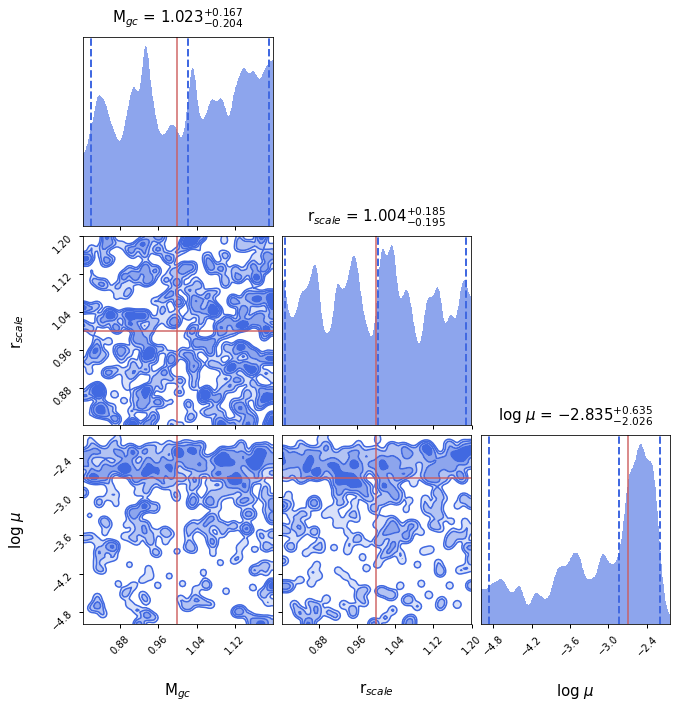

In [149]:
fig, ax = plt.subplots(3,3,figsize=(10,10))
dyplot.cornerplot(pdsampler.results, truths=[1, 1, np.log10(beta)], labels=[r'M$_{gc}$', 'r$_{scale}$', 'log $\mu$'], 
                  color="royalblue", truth_color="indianred",
                  title_kwargs={'fontsize':15, 'y': 1.04}, title_fmt='.3f',
                  label_kwargs={'fontsize':15}, show_titles=True, fig=(fig,ax))
plt.show()

### Unnormalized Fitting w/ physical $M_{GC}$ and $r_{scale}$

In [115]:
start = time.time()
pdsampler = dynesty.DynamicNestedSampler(loglike, prior, 3)
pdsampler.run_nested(nlive_init=nlive_init, 
                     nlive_batch=nlive_batch, 
                     maxbatch=maxbatch, 
                     dlogz_init=dlogz, 
                     wt_kwargs={'pfrac': pfrac})
end = time.time()
print("Total Time Elapsed : %.1fs"%(end-start))

iter: 872 | batch: 2 | bound: 11 | nc: 2 | ncall: 6201 | eff(%): 14.062 | loglstar: -303222.771 < -303220.475 < -303221.328 | logz: -303224.647 +/-  0.260 | stop:  5.649                             

Total Time Elapsed : 262.3s


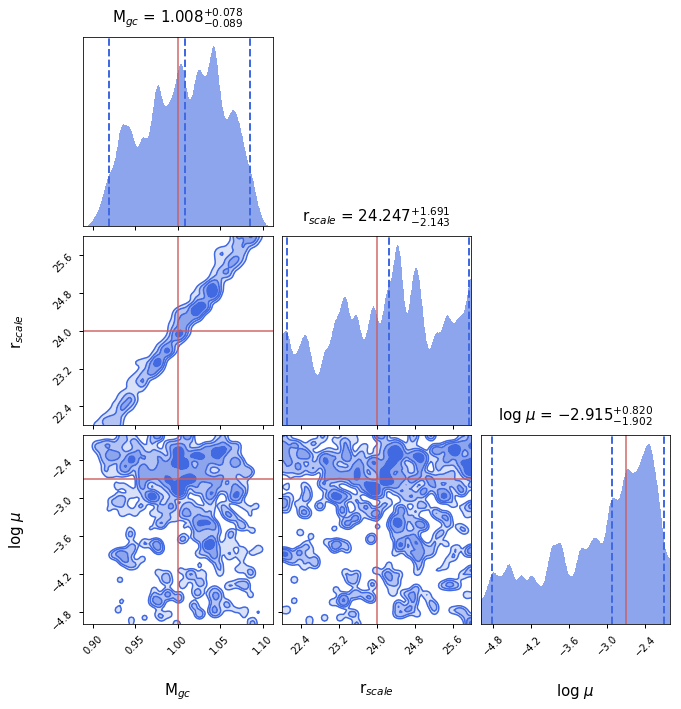

In [117]:
fig, ax = plt.subplots(3,3,figsize=(10,10))
dyplot.cornerplot(pdsampler.results, truths=[M_gc/1e6, r_scale, np.log10(beta)], labels=[r'M$_{gc}$', 'r$_{scale}$', 'log $\mu$'], 
                  color="royalblue", truth_color="indianred",
                  title_kwargs={'fontsize':15, 'y': 1.04}, title_fmt='.3f',
                  label_kwargs={'fontsize':15}, show_titles=True, fig=(fig,ax))
plt.show()

Take a Look at real data radial distribution

In [223]:
drct = r"../data/"
gc_name = "NGC_104_47Tuc"

GC = GlobularCluster.from_directory(gc_name, drct)
GC.df.to_pandas().describe()

,x,y,pmx,pmy,pmx_e,pmy_e,pm_corr,g_mag,bp_rp,filter,memberprob,r,pm
count,90493.000000,90493.000000,90493.000000,90493.000000,90493.000000,90493.000000,90493.000000,90493.000000,72818.000000,90493.000000,90493.000000,90493.000000,90493.000000
mean,0.000156,-0.001003,5.069834,-2.391010,0.748230,0.620638,-0.075671,18.663277,0.902223,0.186291,0.172318,0.155831,5.962009
std,0.120260,0.120338,2.228220,1.715258,0.696715,0.602957,0.200438,1.435548,0.197522,0.389343,0.374415,0.068273,1.944638
min,-0.304802,-0.304871,-18.609150,-18.942380,0.023578,0.020528,-0.951285,10.600150,-1.243570,0.000000,0.000000,0.001046,0.014232
25%,-0.086928,-0.088950,4.563601,-2.982478,0.282561,0.232241,-0.184336,17.860400,0.791438,0.000000,0.000000,0.102253,5.270765
50%,-0.000863,-0.000408,5.225497,-2.455140,0.526232,0.425090,-0.070902,18.809510,0.873425,0.000000,0.000000,0.147533,5.875586
75%,0.087354,0.086612,5.831917,-1.870965,0.970185,0.772030,0.027872,19.691000,0.998234,0.000000,0.000000,0.206166,6.498322
max,0.304218,0.304813,19.767390,19.388680,5.227345,5.189505,0.982183,20.999230,4.339368,1.000000,0.998725,0.304992,19.986477


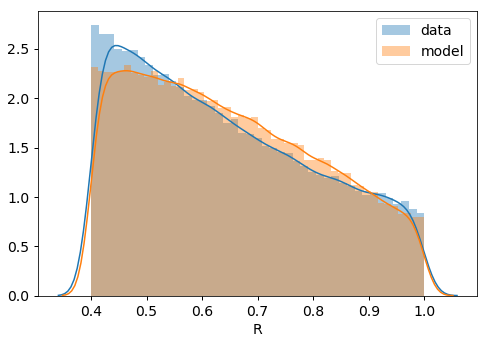

In [283]:
sns.distplot(GC.r[GC.r>0.4], label="data")
plt.xlabel("R")
sns.distplot(x, label="model")
plt.legend()
plt.tight_layout()
# plt.savefig("Tuc47_Model_r.png", png=50)
